How did you start Notebook
--------------------------

When starting this notebook using this:
```bash
~/tutorial-env/bin/ipython notebook --pylab=inline

```
comment out the code in the following cell.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Generate the data necessary to this project first.**

Generated input data is saved in: /tmp/tmpvgFckN


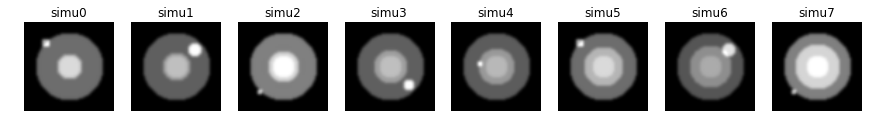

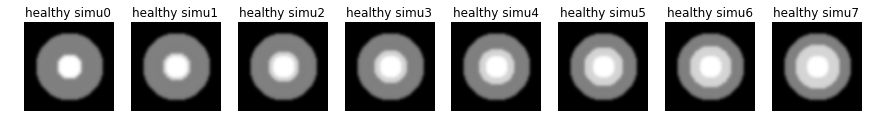

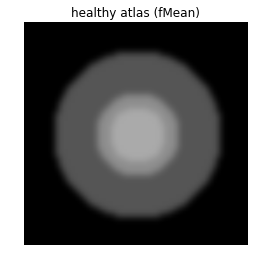

In [3]:
import tempfile
figure()
data_folder=tempfile.mkdtemp()
print "Generated input data is saved in: "+data_folder
%run ../../helper/gen_2D_simulation_data.py $data_folder

In [4]:
import glob
import sys
import os.path
sys.path.append('../')
sys.path.append('../../')
from pyLAR import *
import SimpleITK as sitk

In [5]:
# global parameters
EXE_ConvertToJpg = '/Users/xiaoxiaoliu/work/bin/ANTS/bin/ConvertToJpg'
input_folder = data_folder
result_folder = data_folder +'/forward_UAB_Results'
UAB_result_folder = data_folder +'/UAB_Results'
GT_UAB_result_folder = data_folder +'/GT_UAB_Results'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
if not os.path.exists(UAB_result_folder):
    os.makedirs( UAB_result_folder)
if not os.path.exists(GT_UAB_result_folder):
    os.makedirs( GT_UAB_result_folder)

im_names = glob.glob(input_folder+'/simu*.*')

num_of_data = len(im_names)
x_dim = 64
y_dim = 64

VIS = 0
#print im_names

# data selection
selection = range(num_of_data)
num_of_data = len(selection)


NUM_OF_ITERATIONS = 5

In [6]:
def getImageArray(fn, CONVERT= False):
    if CONVERT:
        img = Image.open(fn).convert('LA')
        newImFn = os.path.splitext(fn)[0]+'.png'
        img.save(newImFn)
        convertToJpg(newImFn)
        os.system('rm '+newImFn)
        newImFn = os.path.splitext(fn)[0]+'.jpg'
        fn = newImFn
    
    im = sitk.ReadImage(fn)
    im_array = sitk.GetArrayFromImage(im)
    return im_array

def convertToJpg(fn):
    outputFn = os.path.splitext(fn)[0]+'.jpg'
    cmd = EXE_ConvertToJpg + ' ' + fn + ' ' + outputFn
    os.system(cmd)
    return outputFn

Simulated Bullseye dataset with added varying-size circles:


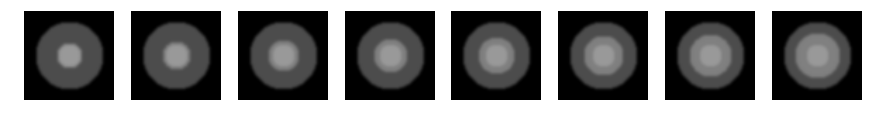

In [7]:
print 'Simulated Bullseye dataset with added varying-size circles:'
plt.figure(figsize=(15,5)) 
for i in range(num_of_data):
        #fn = im_names[selection[i]]
        fn = data_folder+'/healthySimu'+str(i)+'.nrrd'
        im_array = getImageArray(fn)
        plt.subplot(1,num_of_data,i+1)
        plt.imshow(im_array,cm.gray,vmin = 0, vmax = 100) 
        plt.axis('off')  
        iter0Fn = result_folder+'/Iter0_'+str(i)+'.nrrd'
       
        im = sitk.GetImageFromArray(im_array)
        sitk.WriteImage(im,iter0Fn)


**Configure software paths in cell below**

In [13]:
EXE_ANTS = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/antsRegistration'
EXE_WarpImageMultiTransform = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/WarpImageMultiTransform'
EXE_CreateJacobianDeterminantImage = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/CreateJacobianDeterminantImage'

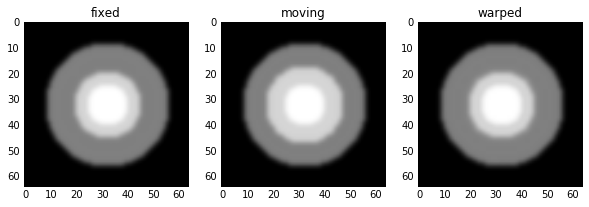

In [14]:
# Testing ANTS registration, set parameters
fixedIm =  result_folder+'/Iter0_'+str(4)+'.nrrd'
movingIm =  result_folder+'/Iter0_'+str(6)+'.nrrd'

antsParams =  {
'Dimension': 2,\
'Convergence' : '[200x100,1e-6,10]',\
'ShrinkFactors' : '2x1',\
'SmoothingSigmas' : '1x0vox',\
'Transform' :'SyN[0.1,1,0]',\
#'Metric': 'Mattes[%s,%s,1,50]' %(fixedIm, movingIm)
'Metric': 'MeanSquares[fixedIm,movingIm, 1,0]' # the file name will be replaced inside the ANTS()
}
# Mattes[f,m ,weight, histogramb_in_size,samplingmethod, samplingPercentage]     
#'Metric': 'Mattes[%s,%s,1,50]' %(fixedIm, movingIm)}

cmd = ANTS(EXE_ANTS, fixedIm, movingIm,result_folder+'/test',antsParams)
#print cmd
os.system(cmd)
warpedImFn = result_folder+ '/testWarped.nrrd'
#warpedImFn = convertToJpg(warpedImFn)

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.title('fixed')
plt.imshow(getImageArray(fixedIm),cm.gray) 
plt.subplot(132)
plt.title('moving')
plt.imshow(getImageArray(movingIm),cm.gray) 
plt.subplot(133)
plt.title('warped')
plt.imshow(getImageArray(warpedImFn),cm.gray) 


In [10]:
def saveImagesFromDM(D, filePrefix):
    for i in range(num_of_data):
        im_array = np.array(D[:,i].reshape(x_dim, y_dim))
        im = sitk.GetImageFromArray(im_array)
        sitk.WriteImage(im,filePrefix +str(i)+ '.nrrd')
        
def averageImageFromDM(D, fileName):        
        m = np.average(D,1)
        aver = m.reshape(x_dim,y_dim)
        im = sitk.GetImageFromArray(aver)
        sitk.WriteImage(im,fileName)
        
def weightedAverageImageFromDM(D, W, fileName):     
        s = np.sum(W,1)
        DD = np.multiply(D,W)
        m = np.sum(DD,1)
        for i in range(D.shape[0]):
            m[i] = np.round(np.divide(m[i],s[i]))
        aver = m.reshape(x_dim,y_dim)
        im = sitk.GetImageFromArray(aver)
        sitk.WriteImage(im,fileName)
        
        
def showSlice(D, titleN,color,row, referenceIm=None):
    for i in range(num_of_data):
       im = np.array(D[:,i].reshape(x_dim,y_dim))
        
       plt.subplot2grid((3,num_of_data),(row,i))
       plt.imshow(diff,cm.gray,vmin = -80, vmax = 80)
       plt.axis('off')
       plt.title(titleN+' '+str(i))

In [15]:
# traditional unbiased atlas building (UAB)
def runUABIteration_Forward(currentIter,result_path):
     
    atlasIm = result_path + '/average_UAB_iter'+str(currentIter-1)+'.nrrd'
    
    for i in range(num_of_data):
        initialInputImage = result_path+'/Iter0_' +str(i) +  '.nrrd'
        newInputImage = result_path+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
          
        # deform with an intial moving transform from previous iteration
        initialTransform = None
            
        outputTransformPrefix = result_path +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
        # usage: ANTS(fixedIm,movingIm,outputTransformPrefix,params,initialTransform=None, EXECUTE = False):
        # in forward unbiased atlas building, the atlas image is the moving image
        cmd = ANTS(EXE_ANTS, initialInputImage,atlasIm, outputTransformPrefix,antsParams, initialTransform, True)

        ## ANTSWarp2DImage(inputIm, outputIm, referenceIm, transformPrefix,inverse = False, EXECUTE = False):
        # apply the inverse transform to warp each input image back to the atlas image space
        ANTSWarp2DImage(EXE_WarpImageMultiTransform, initialInputImage,newInputImage, atlasIm,outputTransformPrefix, True,True)
          
   
    # JD weighted avearage
    A = np.zeros((x_dim*y_dim,num_of_data),dtype=float32)
    JD = np.zeros((x_dim*y_dim,num_of_data),dtype=float32)
    #plt.figure()
    for i in range(num_of_data):
        fn = result_path+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        im_array = getImageArray(fn)
        A[:,i] = im_array.reshape(-1)
        
       # jdFilter = sitk.DisplacementFieldJacobianDeterminantFilter()
        dvfFile =  result_path +'/Iter' + str(currentIter) +'_'+str(i)+'_' +'0Warp.nii.gz'
       # outIm = jdFilter.Execute(dvfFile)
       # jdImArray = sitk.GetArrayFromImage(outIm)
        outIm = result_path +'/Iter' + str(currentIter) +'_'+str(i)+'_' +'0Warp_JD.nrrd'
        createJacobianDeterminantImage(EXE_CreateJacobianDeterminantImage, 2,dvfFile, outIm,True)                                    
        jdImArray = getImageArray(outIm)
       # plt.subplot(1,num_of_data,i+1)
        plt.figure()
        plt.imshow(jdImArray, cm.gray)
        plt.title('JD'+str(i))
        JD[:,i] = jdImArray.reshape(-1)
        
    newAtlasIm = result_path + '/average_UAB_iter'+str(currentIter)+'.nrrd'  
    
    weightedAverageImageFromDM(A,JD, newAtlasIm)
        
    newAtlas = getImageArray(newAtlasIm)

    plt.subplot(1,NUM_OF_ITERATIONS+2,currentIter+1)
    plt.imshow(newAtlas,cm.gray,vmin = 0, vmax = 80)
    plt.title( 'Iter %s UAB atlas' %(currentIter))
    plt.axis('off')
          
       
    return


def runUABIteration(currentIter,result_path):
     
    atlasIm = result_path + '/average_UAB_iter'+str(currentIter-1)+'.nrrd'
    
    for i in range(num_of_data):
        initialInputImage = result_path+'/Iter0_' +str(i) +  '.nrrd'
        newInputImage = result_path+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
          
        # deform with an intial moving transform from previous iteration
        initialTransform = None
            
        outputTransformPrefix = result_path +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
        # usage: ANTS(fixedIm,movingIm,outputTransformPrefix,params,initialTransform=None, EXECUTE = False):
        cmd = ANTS(EXE_ANTS, atlasIm, initialInputImage,outputTransformPrefix,antsParams, initialTransform, True)
        # Update input image to update the average image
        ## ANTSWarp2DImage(inputIm, outputIm, referenceIm, transformPrefix,inverse = False, EXECUTE = False):
        # ANTSWarp2DImage(initialInputImage,newInputImage, atlasIm,outputTransformPrefix, False,True)
        
        
        #dvfFile =  result_path +'/Iter' + str(currentIter) +'_'+str(i)+'_' +'0InverseWarp.nii.gz'
        #outIm = result_path +'/Iter' + str(currentIter) +'_'+str(i)+'_' +'0InverseWarp_JD.nrrd'
        #createJacobianDeterminantImage(2,dvfFile, outIm,True)                                    
        #jdImArray = getImageArray(outIm)
        #plt.figure()
        #plt.imshow(jdImArray, cm.gray)
        #plt.title('JD'+str(i))
   
    A = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data):
        #fn = result_path+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        fn = result_path+'/Iter'+ str(currentIter)+'_' +str(i)+'_Warped.nrrd'
        im_array = getImageArray(fn)
        A[:,i] = im_array.reshape(-1)
    newAtlasIm = result_path + '/average_UAB_iter'+str(currentIter)+'.nrrd'  
    averageImageFromDM(A,newAtlasIm)
        
    newAtlas = getImageArray(newAtlasIm)

    plt.subplot(1,NUM_OF_ITERATIONS+2,currentIter+1)
    plt.imshow(newAtlas, cm.gray)
    plt.title( 'Iter %s UAB atlas' %(currentIter))
    plt.axis('off')
          
       
    return


###################################### run UAB #######################

def  runUAB(result_path,type = 0):
    Y = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data):
        fn = result_path +'/Iter0_'+str(i)+'.nrrd'
        im_array = getImageArray(fn)
        Y[:,i] = im_array.reshape(-1)
    m = np.average(Y,1)
    atlas = m.reshape(x_dim,y_dim)
    im = sitk.GetImageFromArray(atlas) 
    sitk.WriteImage(im,result_path +'/average_UAB_iter0.nrrd')
    plt.figure(figsize=(20,10))
    plt.subplot(1,NUM_OF_ITERATIONS+2,1)
    plt.imshow(atlas, cm.gray,vmin = 0, vmax = 80)
    plt.title( 'Iter 0 UAB atlas')
    plt.axis('off')
    
    for k in range(1,NUM_OF_ITERATIONS+1):
        print 'iter'+str(k)
        if (type == 1):
          runUABIteration_Forward(k,result_path)
        else:
          runUABIteration(k,result_path)
    
    ###########  comparison vis #############
    fn = data_folder + '/fMeanSimu'+'.nrrd'
    im_array_gt = getImageArray(fn)

    fn = result_path + '/average_UAB_iter'+str(NUM_OF_ITERATIONS)+'.nrrd'
    im_array = getImageArray(fn)
    
   
    diff = im_array - im_array_gt
    print 'max =',np.max(diff)
    print 'min =',np.min(diff)
    print 'std=', np.std(diff)
    
    plt.subplot(1,NUM_OF_ITERATIONS+2,NUM_OF_ITERATIONS+2)
    plt.imshow(diff,cm.gray)
    plt.title('diff')
    plt.axis('off') 
    
    a = sum(sum(pow(diff,2)))
    print 'total ssd = ',a
    return a


iter1
iter2
iter3
iter4
iter5
max = 6.27449
min = -2.89479
std= 1.04792
total ssd =  4714.6


/home/fbudin/tutorial-env/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


4714.605

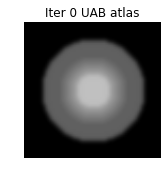

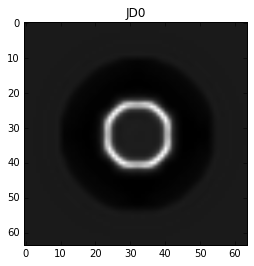

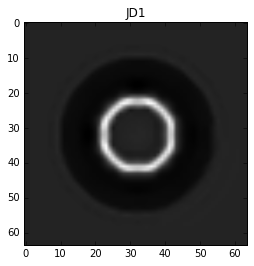

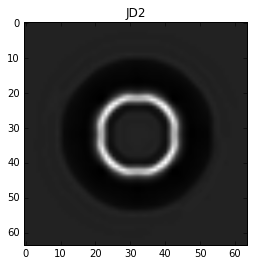

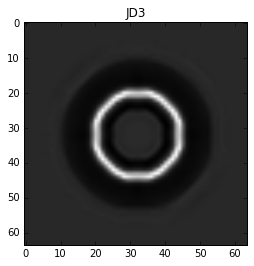

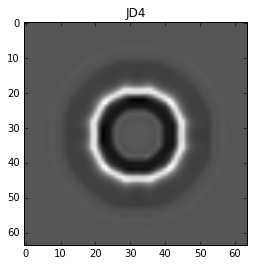

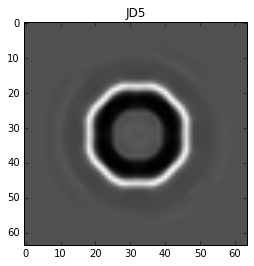

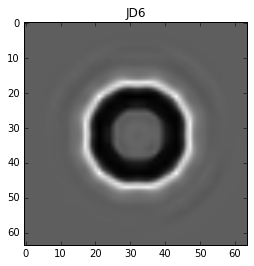

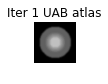

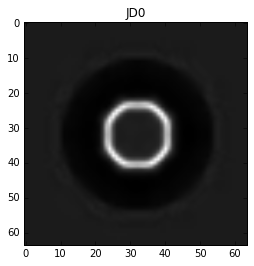

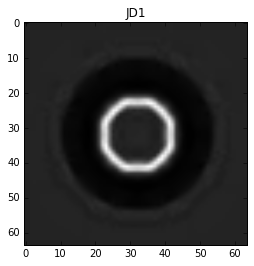

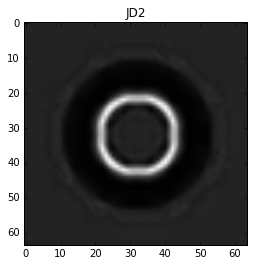

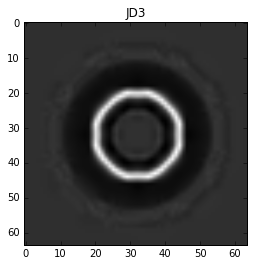

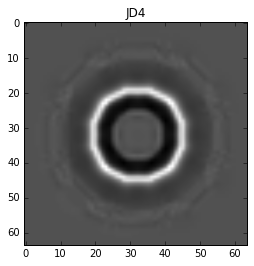

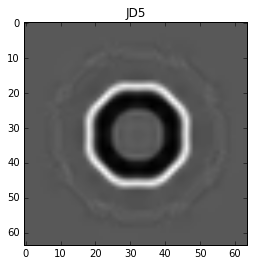

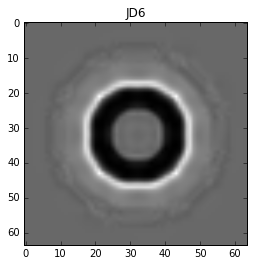

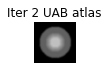

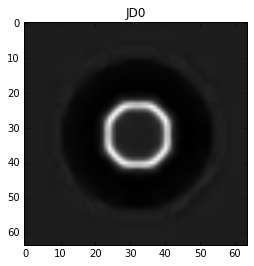

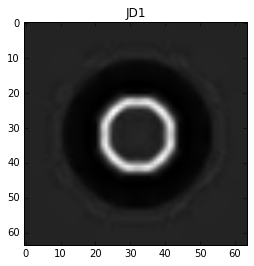

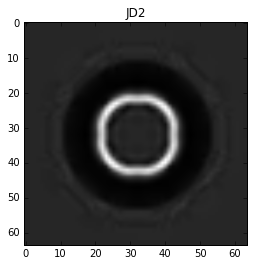

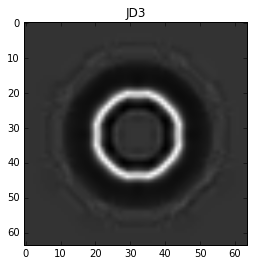

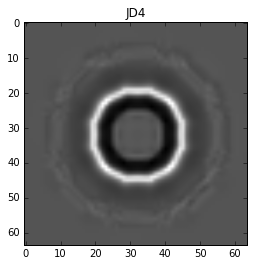

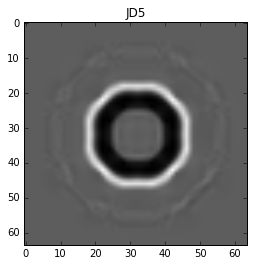

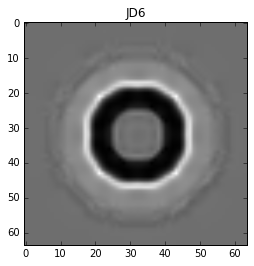

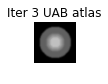

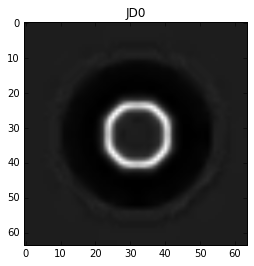

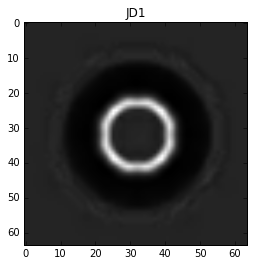

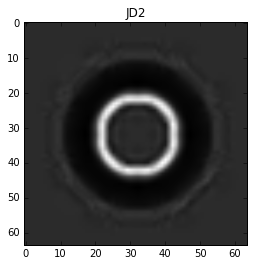

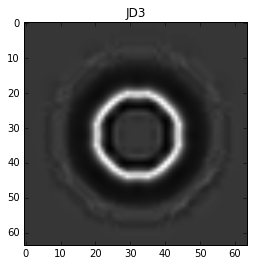

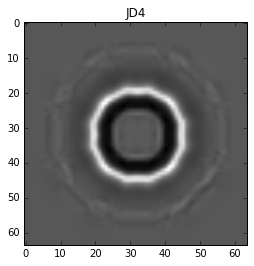

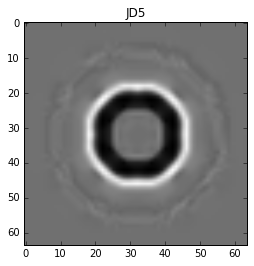

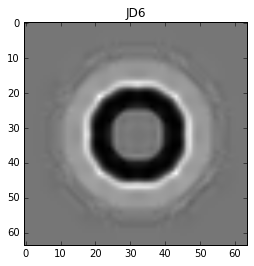

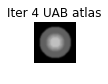

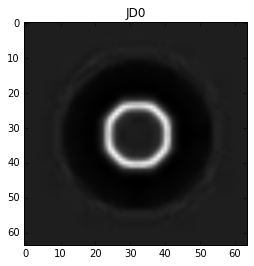

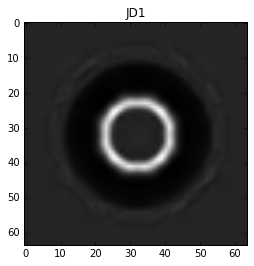

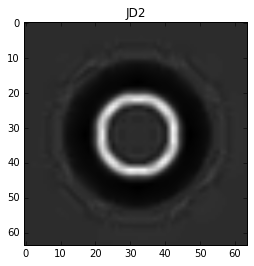

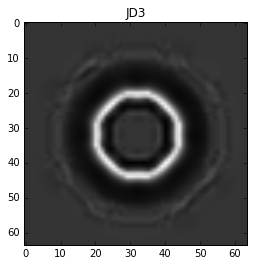

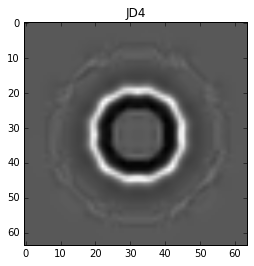

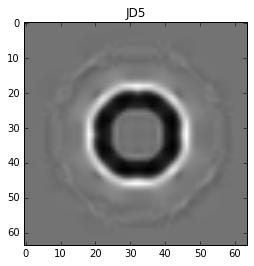

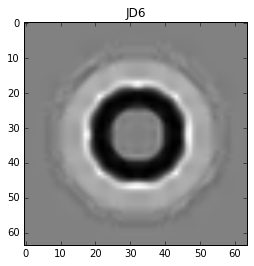

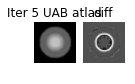

In [16]:
#runUAB(result_folder,0)
runUAB(result_folder,1) #forward


In [21]:
###############################  the main LAB (low-rank atlas building) pipeline #############################

def runLABIteration_Forward(currentIter, sigma,lamda):
    # run RPCA
    Y = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data) :
        im_file =  result_folder+'/'+ 'Iter'+str(currentIter - 1)+'_' + str(i)  + '.nrrd'  
        inIm = sitk.ReadImage(im_file)
        outIm = inIm
        if sigma > 0:
            srg = sitk.SmoothingRecursiveGaussianImageFilter()
            srg.SetSigma(sigma)
            outIm = srg.Execute(inIm)
        tmp = sitk.GetArrayFromImage(outIm)
        Y[:,i] = tmp.reshape(-1)
    
    low_rank, sparse, n_iter,rank, sparsity, sparseness = rpca(Y,lamda)
    saveImagesFromDM(low_rank,result_folder+'/'+ 'Iter'+str(currentIter) +'_LowRank_')
    saveImagesFromDM(sparse,result_folder+'/'+ 'Iter'+str(currentIter) +'_Sparse_')
    
    
    # visualize and inspect
    if VIS == 1:
        fig = plt.figure(figsize=(15,5))
        showSlice(Y, 'Iter'+str(currentIter) +' Input',cm.gray,0)    
        showSlice(low_rank,'Iter'+str(currentIter) +' low rank',cm.gray,1)
        showSlice(sparse,'Iter'+str(currentIter) +' sparse',cm.gray,2)
        savefig(result_folder+'/'+'Iter'+ str(currentIter)+'.png')
    
    
     # Compute the mean of low_rank as the atlas image
    atlasIm = result_folder + '/average_iter'+str(currentIter)+'.nrrd'
    if currentIter == 1 :
        averageImageFromDM(low_rank,atlasIm)     
    else:
        A = np.zeros((x_dim*y_dim,num_of_data),dtype=float32)
        JD = np.zeros((x_dim*y_dim,num_of_data),dtype=float32)
        for i in range(num_of_data):
            # get inverse transformed low rank image
            lowRankIm = result_folder+'/'+ 'Iter'+str(currentIter)+'_LowRank_' + str(i)  +'.nrrd'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
            previousOutputTransformPrefix = result_folder+'/Iter'+ str(currentIter-1)+'_'+str(i)+'_'
            # generate inverse warped low-rank image to align with the intial input image space
            ANTSWarp2DImage(EXE_WarpImageMultiTransform, lowRankIm,invWarpedlowRankIm, lowRankIm,previousOutputTransformPrefix,False, True)
            
            # generate JD weighted average low-rank atlas
            tmp = getImageArray(lowRankIm)
            A[:,i] = tmp.reshape(-1)                
            dvfFile =  result_folder +'/Iter' + str(currentIter) +'_'+str(i)+'_' +'0InverseWarp.nii.gz'    
            outIm = result_folder +'/Iter' + str(currentIter) +'_'+str(i)+'_' +'0InverseWarp_JD.nrrd'
            createJacobianDeterminantImage(EXE_CreateJacobianDeterminantImage, 2,dvfFile, outIm,True)                                    
            jdImArray = getImageArray(outIm)
            JD[:,i] = jdImArray.reshape(-1)
        weightedAverageImageFromDM(A,JD, atlasIm)
        

    # register low-rank images to the atlas(average) image
    for i in range(num_of_data):
        newInputImage = result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        initialInputImage = result_folder+'/Iter0_' +str(i) +  '.nrrd'

        # deform with an intial moving transform from previous iteration
        initialTransform = None
        invWarpedlowRankIm = result_folder+'/'+ 'Iter1_LowRank_' + str(i)  +'.nrrd'
        if currentIter > 1:
           # initialTransform = result_folder + '/Iter'+str(currentIter-1)+'_'+str(i)+'_0Warp.nii.gz'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
        # register the inversely warped low rank image to the atlas image
        outputTransformPrefix = result_folder +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
        
        # atlas is the moving image
        cmd = ANTS(EXE_ANTS, invWarpedlowRankIm,atlasIm, outputTransformPrefix,antsParams, initialTransform, True)
  
        # Update input image for the next iteration
        
        # use the inverse warp to get the updated input image
        ANTSWarp2DImage(EXE_WarpImageMultiTransform, initialInputImage,newInputImage, atlasIm,outputTransformPrefix, True,True)
       
    return
    
       


def runLABIteration(currentIter, sigma,lamda):
    # run RPCA
    Y = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data) :
        im_file =  result_folder+'/'+ 'Iter'+str(currentIter - 1)+'_' + str(i)  + '.nrrd'  
        inIm = sitk.ReadImage(im_file)
        outIm = inIm
        if sigma > 0:
            srg = sitk.SmoothingRecursiveGaussianImageFilter()
            srg.SetSigma(sigma)
            outIm = srg.Execute(inIm)
        tmp = sitk.GetArrayFromImage(outIm)
        Y[:,i] = tmp.reshape(-1)
    
    low_rank, sparse, n_iter,rank, sparsity, sparseness = rpca(Y,lamda)
    saveImagesFromDM(low_rank,result_folder+'/'+ 'Iter'+str(currentIter) +'_LowRank_')
    saveImagesFromDM(sparse,result_folder+'/'+ 'Iter'+str(currentIter) +'_Sparse_')
    
    
    # visualize and inspect
    if VIS == 1:
        fig = plt.figure(figsize=(15,5))
        showSlice(Y, 'Iter'+str(currentIter) +' Input',cm.gray,0)    
        showSlice(low_rank,'Iter'+str(currentIter) +' low rank',cm.gray,1)
        showSlice(sparse,'Iter'+str(currentIter) +' sparse',cm.gray,2)
        savefig(result_folder+'/'+'Iter'+ str(currentIter)+'.jpg')
    
    
     # Compute the mean of low_rank as the atlas image
    atlasIm = result_folder + '/average_iter'+str(currentIter)+'.nrrd'
    if currentIter == 1 :
        averageImageFromDM(low_rank,atlasIm)     
    else:
        A = np.zeros((x_dim*y_dim,num_of_data))
        for i in range(num_of_data):
            # get inverse transformed low rank image
            lowRankIm = result_folder+'/'+ 'Iter'+str(currentIter)+'_LowRank_' + str(i)  +'.nrrd'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
            previousOutputTransformPrefix = result_folder+'/Iter'+ str(currentIter-1)+'_'+str(i)+'_'
            ANTSWarp2DImage(EXE_WarpImageMultiTransform, lowRankIm,invWarpedlowRankIm, lowRankIm,previousOutputTransformPrefix,True, True)
            tmp = getImageArray(lowRankIm)
            A[:,i] = tmp.reshape(-1)
        averageImageFromDM(A,atlasIm)
        
    atlas = getImageArray(atlasIm)
   
    # register low-rank images to the atlas(average) image
    for i in range(num_of_data):
        newInputImage = result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        initialInputImage = result_folder+'/Iter0_' +str(i) +  '.nrrd'

        # deform with an intial moving transform from previous iteration
        initialTransform = None
        invWarpedlowRankIm = result_folder+'/'+ 'Iter1_LowRank_' + str(i)  +'.nrrd'
        if currentIter > 1:
           # initialTransform = result_folder + '/Iter'+str(currentIter-1)+'_'+str(i)+'_0Warp.nii.gz'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
        # register the inversely warped low rank image to the atlas image
        outputTransformPrefix = result_folder +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
        cmd = ANTS(EXE_ANTS, atlasIm, invWarpedlowRankIm,outputTransformPrefix,antsParams, initialTransform, True)
        #print cmd
        # Update input image for the next iteration
        ANTSWarp2DImage(EXE_WarpImageMultiTransform, initialInputImage,newInputImage, atlasIm,outputTransformPrefix, False,True)
       
    return
    
    
######################################## Run Low-rank Atlas Buildling #######################
def  runLAB(lamda,type = 0):
    print "lamda = ",lamda
    sigma = 0
    for k in range(1,NUM_OF_ITERATIONS+1):
        print 'iter'+str(k)
        if type == 0:
           runLABIteration(k,sigma,lamda)
        else:
           runLABIteration_Forward(k,sigma,lamda)
    print " low-rank atlas over iterations"
    plt.figure(figsize=(15,10))
    for currentIter in range(1,NUM_OF_ITERATIONS):
        fn = result_folder+ '/average_iter'+ str(currentIter) +'.nrrd'
        im_array = getImageArray(fn)
        plt.subplot(1,NUM_OF_ITERATIONS,currentIter)
        plt.imshow(im_array,cm.gray) 
        plt.title( 'LAB Iter'+str(currentIter))
    
    ###########  comparison vis #############
    plt.figure(figsize=(15,5))
    fn = result_folder + '/average_iter'+str(NUM_OF_ITERATIONS)+'.nrrd'
    im_array_ula = getImageArray(fn)

    fn =data_folder + '/fMeanSimu'+'.nrrd'
    im_array_gt = getImageArray(fn)
   
    diff = im_array_ula-im_array_gt
    plt.title('diff')
    plt.imshow(diff,cm.gray)

    print 'max =',np.max(diff)
    print 'min =',np.min(diff)

    a = sum(sum(pow(diff,2)))
    print 'total ssd = ',a
    return a


lamda =  1.0
iter1
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=0.0883790835, total sparse =0000
[iter: 0010]: rank(P) = 0005, |C|_0 = 1512, crit=0.0036427275, total sparse =2871
[iter: 0020]: rank(P) = 0008, |C|_0 = 2804, crit=0.0000434365, total sparse =3120
RPCA takes:0.143323 seconds
iter2
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=0.0245301344, total sparse =0000
[iter: 0010]: rank(P) = 0003, |C|_0 = 0786, crit=0.0076539000, total sparse =0934
[iter: 0020]: rank(P) = 0008, |C|_0 = 2379, crit=0.0000030668, total sparse =1288
RPCA takes:0.135017 seconds
iter3
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=0.0120646602, total sparse =0000
[iter: 0010]: rank(P) = 0002, |C|_0 = 0647, crit=0.0062700162, total sparse =0531
[iter: 0020]: rank(P) = 0008, |C|_0 = 2460, crit=0.0000038844, total sparse =0817
RPCA takes:0.147889 seconds
iter4
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=0.0103164803, total sparse =0000
[iter: 0010]: rank(P) = 0002, |C|_0 = 0602, crit=0.00624343

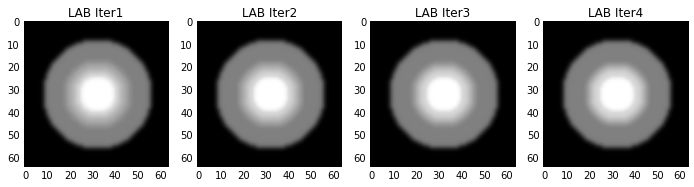

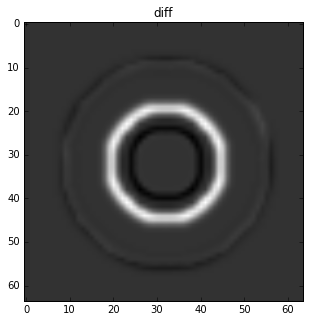

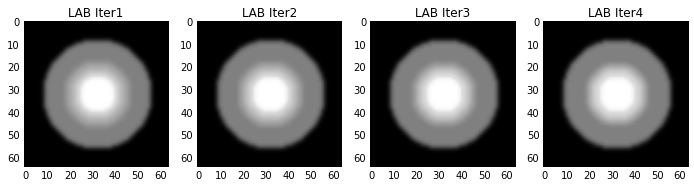

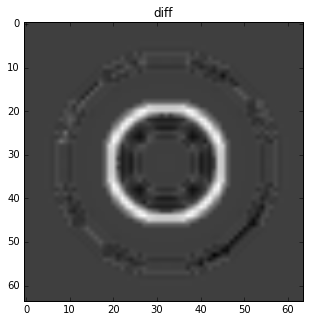

In [22]:
a = runLAB(1.0, 0 )
b = runLAB(1.0, 1 ) # forward
